<a href="https://colab.research.google.com/github/Ketian-Wang/RobotLearning/blob/main/mece6616_Spring2023_Project4_benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project Setup 

In [ ]:
# DO NOT CHANGE

# After running this cell, the folder 'mecs6616_sp23_project3' will show up in the file explorer on the left (click on the folder icon if it's not open)
# It may take a few seconds to appear
!git clone https://github.com/roamlab/mecs6616_sp23_project4.git

Cloning into 'mecs6616_sp23_project4'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 15 (delta 5), reused 6 (delta 0), pack-reused 0
Unpacking objects: 100% (15/15), 8.63 KiB | 2.16 MiB/s, done.


In [ ]:
# DO NOT CHANGE

# move all needed files into the working directory. This is simply to make accessing files easier
!mv /content/mecs6616_sp23_project4/* /content/

In [ ]:
!pip install ray

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 84.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 87.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.5/468.5 kB 43.8 MB/s eta 0:00:00
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.54.0
    Uninstalling grpcio-1.54.0:
      Successfully uninstalled grpcio-1.54.0


# Starter Code Explanation

This project uses the same environment as in project 3 which consists of an n linked robot arm. The code for teacher dynamics and the controller is provoded. And the scripts for collecting data, skeleton classes for implementing student dynamics and finally training and evaluating the model are also provided.

Similar to last time we define a Robot class inside `robot.py` which provides the interface for controlling the robot arm i.e it provides you with some functions to set/get the state and set the action for the arm and take a step using the `Robot.advance()` method. The state of the arm is a 2n-dimensional vector : n joint positions [rad] + n joint velocities [rad/s] and the action is defined as the n torques (in N-m) applied to n joints respectively.

The `arm_dynamic_base.py` defines the base class for forward dynamics for the arm. The ground truth forward dynamics are defined in `arm_dynamics_teacher.py`. The student dynamics which internally uses a neural network model is defined in `arm_dynamics_student.py`


The `models.py` file provides the base class for neural network to learn forward model and also contains skeleton code for you to implement the network architecture for arms with different number of links. We will revisit this again in when providing instructions for training below.

## Part 1: Implement Model Predictive Control

This section will implement this controller by completing the MPC class. Specifically, this section will implement the compute_action() method by following the algorithm discussed in the lecture. As with previous projects you are free to implement additional methods as needed or change the initialization if need be. While scoring your controller, this section will be creating an instance of the MPC class and passing it to the scoring function so ensure that the arguments to the compute_action method remain the same.

The velocity of the end effector can be computed with the code below:
```
pos_ee = dynamics.compute_fk(state)
vel_ee = dynamics.compute_vel_ee(state)
```


In [ ]:
from collections import defaultdict
import numpy as np
class MPC:

  def __init__(self):
        self.control_horizon = 10
        self.repeat_n = 40
        self.delta_u_max = 0.1
        self.delta_u_min = 0.01
        self.delta_u_decay = 0.99
        self.position_weight = 80
        self.velocity_weight = 1
        self.update_max = 40



  def compute_cost(self, dynamics, trajectory, goal):
        position_error = 0
        velocity_error = 0
        # print(trajectory)
        for state in trajectory:
            pos_ee = dynamics.compute_fk(state)
            position_error += np.linalg.norm(goal - pos_ee)**2
            vel_ee = dynamics.compute_vel_ee(state)
            velocity_error += np.linalg.norm(vel_ee)**2
   
        # vel_ee = dynamics.compute_vel_ee(state)
        # velocity_error = np.linalg.norm(vel_ee)**2
        # print('position_error', position_error)
        # print('velocity_error', velocity_error)
        cost = position_error * self.position_weight + velocity_error * self.velocity_weight
        return cost


  def rollout_trajectory(self, dynamics, state, U):
        num_steps = len(U)
        trajectory = [np.zeros_like(state) for _ in range(num_steps+1)]
        # trajectory[0] = state
        for i in range(len(U)):
            state = dynamics.advance(state, U[0])
            trajectory[i] = state
        return trajectory

  def compute_action(self, dynamics, state, goal, action):
    # Put your code here. You must return an array of shape (num_links, 1)
        N = self.repeat_n
        H = self.control_horizon
        num_joints = dynamics.get_action_dim()
        # print('action', action)
        best_action = np.copy(action).reshape(-1)
        U_star = np.tile(best_action, (N, 1))

        for i in range(num_joints - 1, -1, -1): # update from the largest joint
             best_cost = float('inf')
             update_flag = True
             update_counter = 0

             while update_flag and update_counter < self.update_max:

                    
                    update_counter += 1
                    Du = self.delta_u_max * self.delta_u_decay ** update_counter
                    Du = np.max([Du, self.delta_u_min])
                    U_i_plus = np.copy(U_star)
                    U_i_minu = np.copy(U_star)
                    U_i_plus[:, i] += Du
                    U_i_minu[:, i] -= Du

                    trajectory_i_plus = self.rollout_trajectory(dynamics, state, U_i_plus)
                    cost_i_plus = self.compute_cost(dynamics, trajectory_i_plus, goal)
                    trajectory_i_minu = self.rollout_trajectory(dynamics, state, U_i_minu)
                    cost_i_minu = self.compute_cost(dynamics, trajectory_i_minu, goal)

                    min_cost = np.min([best_cost, cost_i_plus, cost_i_minu])


                    update_flag = False
                    if min_cost < best_cost:
                        update_flag = True
                        # print('update')
                        best_cost = min_cost
                        index = np.argmin([cost_i_plus, cost_i_minu])
                        combi = [U_i_plus, U_i_minu]
                        U_star =  combi[index]

        result = U_star[0].reshape([-1, 1])

        return result

# Manually testing the controller
Every time step within the environment is 0.01s, which is defined in the dynamics as `dt`.

The MPC class has a `control_horizon` variable which represents the frequency at which `controller.compute_action()` will be called

In the scoring function the distance of your end effector of the goal position and the velocity of the end effector will be evaluated.

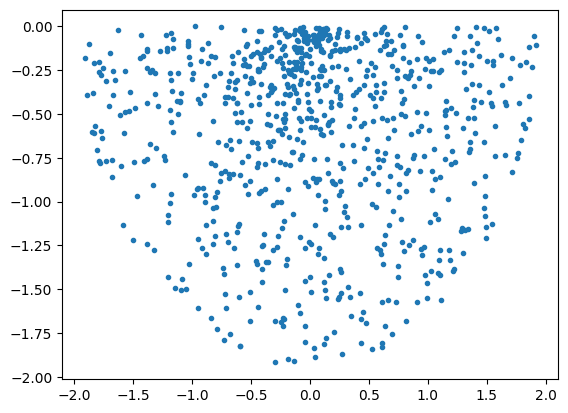

In [ ]:
# !!not important!!
goal =[]
np.random.seed(0)
import matplotlib.pyplot as plt

def sample_goal():
  goal = np.zeros((2,1))
  r = np.random.uniform(low=0.05, high=1.95)
  theta = np.random.uniform(low=np.pi, high=2.0*np.pi)
  goal[0,0] = r * np.cos(theta)
  goal[1,0] = r * np.sin(theta)
  return goal
for i in range(800):
    x, y = sample_goal()
    goal.append((x, y))

# Create a scatter plot of the goals
x_coords = [g[0] for g in goal]
y_coords = [g[1] for g in goal]
plt.scatter(x_coords, y_coords, marker = '.')

In [ ]:
import sys
import numpy as np
from arm_dynamics_teacher import ArmDynamicsTeacher
from robot import Robot
from render import Renderer
from score import *
import torch
import time
import math
np.set_printoptions(suppress=True)

# Teacher arm with 3 links
dynamics_teacher = ArmDynamicsTeacher(
    num_links=2,
    link_mass=0.1,
    link_length=1,
    joint_viscous_friction=0.1,
    dt=0.01)

arm = Robot(dynamics_teacher)
arm.reset()

gui = False
if gui:
  renderer = Renderer()
  time.sleep(1)

# Controller
controller = MPC()

# Resetting the arm will set its state so that it is in the vertical position,
# and set the action to be zeros
arm.reset()

def sample_goal():
  goal = np.zeros((2,1))
  r = np.random.uniform(low=0.05, high=1.95)
  theta = np.random.uniform(low=np.pi, high=2.0*np.pi)
  goal[0,0] = r * np.cos(theta)
  goal[1,0] = r * np.sin(theta)
  return goal

# Choose the goal position you would like to see the performance of your controller
goal = np.zeros((2, 1))
goal[0, 0] = -0.05
goal[1, 0] = 0
arm.goal = goal

dt = 0.01
time_limit = 2.5
num_steps = round(time_limit/dt)

action = np.zeros([dynamics_teacher.num_links, 1])

# print(arm.goal)

dist_roc  = []
# test loop
from tqdm import tqdm 
for _ in tqdm(range(400)):
  # arm.goal = sample_goal()

  for s in range(num_steps):
    t = time.time()
    arm.advance()

    if gui:
      renderer.plot([(arm, "tab:blue")])
    # time.sleep(max(0, dt - (time.time() - t)))

    if s % controller.control_horizon==0:
      state = arm.get_state()

      # Measuring distance and velocity of end effector
      pos_ee = dynamics_teacher.compute_fk(state)
      dist = np.linalg.norm(arm.goal-pos_ee)
      vel_ee = np.linalg.norm(arm.dynamics.compute_vel_ee(state))
      # print(f'At timestep {s}: Distance to goal: {dist}, Velocity of end effector: {vel_ee}')

      action = controller.compute_action(arm.dynamics, state, arm.goal, action)
      # print('action', action)

      arm.set_action(action)
  dist_roc.append(dist)
  if dist > 0.1 or vel_ee > 0.1:
    print('goal', arm.goal)
    print('dist', dist)
    print('vel_ee', vel_ee)

  1%|▏         | 5/400 [00:33<43:20,  6.58s/it]

goal [[-0.05]
 [ 0.  ]]
dist 0.04475736824419409
vel_ee 0.1388879712725387


  2%|▏         | 7/400 [00:50<48:23,  7.39s/it]

goal [[-0.05]
 [ 0.  ]]
dist 0.05044238053586012
vel_ee 0.17936425097612962


  2%|▏         | 8/400 [00:59<52:31,  8.04s/it]

goal [[-0.05]
 [ 0.  ]]
dist 0.05216421890357262
vel_ee 0.2503062343813329


  3%|▎         | 11/400 [01:20<47:49,  7.38s/it]

goal [[-0.05]
 [ 0.  ]]
dist 0.048380219300653844
vel_ee 0.10557552691713258


  4%|▍         | 17/400 [02:02<42:36,  6.67s/it]

goal [[-0.05]
 [ 0.  ]]
dist 0.04637698222972581
vel_ee 0.12387426388859926


100%|██████████| 400/400 [47:03<00:00,  7.06s/it]


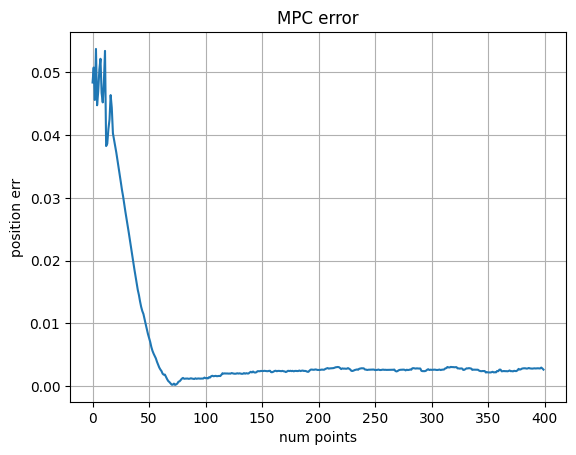

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(dist_roc)
plt.xlabel('num points')
plt.ylabel('position err')
plt.title('MPC error')
# plt.legend(['State 1', 'State 2'])
plt.grid()
plt.show()


## Grading and Evaluation for Part 1
The controller will be graded on 6 tests. 2 tests each for the 1-link ,2-link, and 3-link arms. The arm will start off in the initial state with the arms pointing stright down. The testing criteria depend on the distance and the velocity of the end effectors. Each test will run the robot arm for **5.0 seconds**. At the end of the 5 seconds the test will be:

A success if the end effectors meet this criteria:
`distance_to_goal < 0.1 and vel_ee < 0.5` 

A partial success if the end effectors meet this criteria:
`distance_to_goal < 0.2 and vel_ee < 0.5` 


In [ ]:
# Scoring using score_mpc
controller = MPC()
gui = False

In [ ]:
# DO NOT CHANGE
score_mpc_true_dynamics(controller, gui)


Part1: EVALUATING CONTROLLER (with perfect dynamics)
-----------------------------------------------------
NUM_LINKS: 1
Test  1
Success! :)
 Goal: [ 0.38941834 -0.92106099], Final position: [ 0.38887185 -0.92129186], Final velocity: [0.]
score: 1.5/1.5
Test  2
Success! :)
 Goal: [-0.68163876 -0.73168887], Final position: [-0.70585212 -0.70835922], Final velocity: [0.]
score: 1.0/1.0
NUM_LINKS: 2
Test  1
Success! :)
 Goal: [ 0.6814821  -1.61185674], Final position: [ 0.69232514 -1.61398382], Final velocity: [0.01287573]
score: 1.5/1.5
Test  2
Success! :)
 Goal: [-1.19286783 -1.28045552], Final position: [-1.19588463 -1.27466335], Final velocity: [0.0072852]
score: 1.0/1.0
NUM_LINKS: 3
Test  1
Success! :)
 Goal: [ 1.29444895 -2.36947292], Final position: [ 1.29822715 -2.35144495], Final velocity: [0.04987696]
score: 1.5/1.5
Test  2
Success! :)
 Goal: [-2.10367746 -1.35075576], Final position: [-2.11581901 -1.36929023], Final velocity: [0.06246801]
score: 1.0/1.0
       
----------------

### Part 2.1: Model Architecture
Beyond this point you will be focusing on the 2 link arm only.

The base class Model is subclass for the 2-link arm. The class Model is a base class for the models. In compute_next_state() method, 
this section have to use the trick to use joint accelerations to compute the next state similar to what you did in Project 3.

The `Model2Link` class will use a neural network to compute the joint accelerations by implementing `compute_qddot()` method. This will take 6 values (2 joint angles, 2 joint velocities and 2 actions applied to the arm) and output 2 joint acceleration values

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
	def __init__(self, num_links, time_step):
		super().__init__()
		self.num_links = num_links
		self.time_step = time_step

	def forward(self, x):
		qddot = self.compute_qddot(x)
		state = x[:, :2*self.num_links]
		next_state = self.compute_next_state(state, qddot)
		return next_state

	def compute_next_state(self, state, qddot):
		pos = state[:, :self.num_links]
		vel = state[:, self.num_links: 2 * self.num_links]

		new_vel = vel + qddot * self.time_step
		new_pos = pos + vel * self.time_step + qddot * 0.5 * self.time_step ** 2
		
		output = torch.cat([new_pos, new_vel], dim=1)
		return output

	def compute_qddot(self, x):
		pass

class Model2Link(Model): # 
  def __init__(self, time_step):
    super().__init__(2, time_step)
    # Your code goes here
    self.layer1 = nn.Linear(6, 512)
    self.layer2 = nn.Linear(512,64)
    self.layer3 = nn.Linear(64,2)

  def compute_qddot(self, x):
      y = F.relu(self.layer1(x))
      y = F.relu(self.layer2(y))   
      y = self.layer3(y)
      # print(y)
      # y = self.compute_next_state(state, y)
      return y

  def predict(self, features):
      self.eval()
      features = torch.from_numpy(features).float()
      features = features.unsqueeze(0)
      return self.forward(features).detach().numpy()	    


### Part 2.2: Collect Data
Similar to project 3, the data which will be used to learn a forward model for our 2 link robot arm will be collected. Once a forward model is learnt, it will be evaluated on the MPC Controller that uses the learnt dynamics model instead of the true dynamics.

In [ ]:
# Teacher arm with 2 links
dynamics_teacher = ArmDynamicsTeacher(
    num_links=2,
    link_mass=0.1,
    link_length=1,
    joint_viscous_friction=0.1,
    dt=0.01)

arm = Robot(dynamics_teacher)
arm.reset()

np.random.seed(0)



def collect_data(arm):

  data_collect_MPC = MPC()
  num_points = 800
  num_steps = 250

  def sample_goal():
      goal = np.zeros((2,1))
      r = np.random.uniform(low=0.05, high=1.95)
      theta = np.random.uniform(low=np.pi, high=2.0*np.pi)
      goal[0,0] = r * np.cos(theta)
      goal[1,0] = r * np.sin(theta)
      return goal


  X = np.zeros((num_points * num_steps, arm.dynamics.get_state_dim() + arm.dynamics.get_action_dim()))
  Y = np.zeros((num_points * num_steps, arm.dynamics.get_state_dim()))

  # GUI visualization, this will drastically reudce the speed of the simulator!
  gui = False

  # Initialize the GUI
  if gui:
      renderer = Renderer()
      time.sleep(1)

  init_state = np.zeros((arm.dynamics.get_state_dim(), 1))  
  init_state[0] = -math.pi / 2.0   
  init_action = initial_state = np.zeros((arm.dynamics.get_action_dim(), 1))
  
  
  from tqdm import tqdm 
  for count_point in tqdm(range(num_points)):
    arm.set_state(init_state)
    arm.set_action(init_action)
    arm.goal = sample_goal()
    action = init_action

    for count_step in range(num_steps):
      t = time.time()
      position = count_point * num_steps + count_step
      # print(position)
      state = arm.get_state()
      
      X[position] = np.append(state, action)

      arm.advance()
      state = arm.get_state()
      Y[position] = state.reshape(1, -1)
           
      if gui:
        renderer.plot([(arm, "tab:blue")])
      # time.sleep(max(0, dt - (time.time() - t)))

      if count_step % controller.control_horizon==0:
        action = controller.compute_action(arm.dynamics, state, arm.goal, action)
        #print('action', action)

        arm.set_action(action)
  return X, Y



In [ ]:
import pickle

# Call the function you have defined above to collect data
X, Y = collect_data(arm)
save_dir = 'dataset'
if not os.path.exists(save_dir):
  os.makedirs(save_dir)

# Save the collected data in the data.pkl file
data = {'X': X, 'Y': Y}
pickle.dump(data, open(os.path.join(save_dir, 'data.pkl'), "wb" ))

NameError: ignored

In [ ]:
import pickle
data = {'X': X, 'Y': Y}
pickle.dump(data, open(os.path.join(save_dir, 'data-1.pkl'), "wb" ))

NameError: ignored

In [ ]:
data = pickle.load(open('/content/data-1.pkl', 'rb'))

In [ ]:
data['X'].shape

(200000, 6)

### Part 2.3: Training the forward model

The starter code already creates the dataset class and loads the dataset with a random 0.8/0.2 train/test split for you. This script should save the model that it trains. The specific procedure for saving are outlined as below.

```
model_folder_name = f'epoch_{epoch:04d}_loss_{test_loss:.8f}'
if not os.path.exists(os.path.join(args.save_dir, model_folder_name)):
    os.makedirs(os.path.join(args.save_dir, model_folder_name))
torch.save(model.state_dict(), os.path.join(args.save_dir, model_folder_name, 'dynamics.pth'))
print(f'model saved to {os.path.join(args.save_dir, model_folder_name, "dynamics.pth")}\n')
```
The output from running this code should be a folder as below:

```
models/
    2021-03-24_23-57-50/
        epoch_0001_loss_0.00032930/
            dynamics.pth
        epoch_0002_loss_0.00009413/
            dynamics.pth   
        ...  
```
You can implement the functions below to collect data

In [ ]:
zip_name = "/content/zipped_folder.zip"  # Name of the zip file to be unzipped
destination_folder = "/content/unzipped_folder"  # Folder where you want to save the unzipped content

# Unzip the file
!unzip {zip_name} -d {destination_folder}

Archive:  /content/zipped_folder.zip
   creating: /content/unzipped_folder/content/models/2023-05-06_14-03-38/
   creating: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0049/
  inflating: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0049/dynamics.pth  
   creating: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0013/
  inflating: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0013/dynamics.pth  
   creating: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0075/
  inflating: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0075/dynamics.pth  
   creating: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0185/
  inflating: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0185/dynamics.pth  
   creating: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0063/
  inflating: /content/unzipped_folder/content/models/2023-05-06_14-0

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
import pickle
import torch.optim as optim
import argparse
import time

class DynamicDataset(Dataset):
  def __init__(self, datafile):
    data = pickle.load(open('/content/data-1.pkl', 'rb'))
    # X: (N, 6), Y: (N, 4)
    self.X = data['X'].astype(np.float32)
    self.Y = data['Y'].astype(np.float32)

  def __len__(self):
    return self.X.shape[0]

  def __getitem__(self, idx):
    return self.X[idx], self.Y[idx]

def train_one_epoch(model, loader, optimizer, criterion, scheduler):
    model.train()
    total_loss = 0.0
    for i, data in enumerate(loader):
      x = data[0]
      y = data[1]
      optimizer.zero_grad()
      predictions = model.forward(x)
      loss = criterion(predictions, y)
      loss.backward()
      total_loss += loss.item()
      optimizer.step()
    scheduler.step()
    return total_loss/(i+1)

def test(model, loader, criterion):
    model.eval()
    test_loss = 0.0
    for i, data in enumerate(loader):
      x = data[0]
      y = data[1]
      predictions = model.forward(x)
      loss = criterion(predictions, y)
      loss.backward()
      test_loss += loss.item()
    return test_loss/(i+1)

def train_forward_model():

  # Keep track of the checkpoint with the smallest test loss and save in model_path
  model_path = None
  max_test_loss = 1e4

  network = Model2Link(0.01)  # in consist with the mpc harizon
  learning_rate = 0.00005
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(network.parameters(),lr = learning_rate) #, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)
  batch_size = 128

  datafile = 'dataset/data.pkl'
  split = 0.2
  dataset = DynamicDataset(datafile)
  dataset_size = len(dataset)
  test_size = int(np.floor(split * dataset_size))
  train_size = dataset_size - test_size
  train_set, test_set = random_split(dataset, [train_size, test_size])

  train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

  # The name of the directory to save all the checkpoints
  timestr = time.strftime("%Y-%m-%d_%H-%M-%S")
  model_dir = os.path.join('models', timestr) 

  train_loss_all = []
  test_loss_all = []

  epochs = 200
  min_loss = float('inf')
  from tqdm import tqdm
  for epoch in tqdm(range(1, 1 + epochs)):
    # --
    # Your code goes here
    # --
    total_loss = train_one_epoch(network, train_loader, optimizer, criterion, scheduler)
    print("train loss:", total_loss)
    train_loss_all.append(total_loss)

    test_loss =  test(network, test_loader, criterion)
    print("test loss:", test_loss)
    test_loss_all.append(test_loss)

    model_folder_name = f'epoch_{epoch:04d}'
    if not os.path.exists(os.path.join(model_dir, model_folder_name)):
        os.makedirs(os.path.join(model_dir, model_folder_name))
    torch.save(network.state_dict(), os.path.join(model_dir, model_folder_name, 'dynamics.pth'))
    model_path = os.path.join(model_dir, model_folder_name, 'dynamics.pth')
    
    # if test_loss < min_loss:
    #   min_loss  = test_loss
    #   model_folder_name = f'epoch_{epoch:04d}_loss_{test_loss:.8f}'
    #   if not os.path.exists(os.path.join(model_dir, model_folder_name)):
    #       os.makedirs(os.path.join(model_dir, model_folder_name))
    #   torch.save(network.state_dict(), os.path.join(model_dir, model_folder_name, 'dynamics.pth'))
    #   model_path = os.path.join(model_dir, model_folder_name, 'dynamics.pth')

  return model_path, train_loss_all, test_loss_all

In [ ]:
model_path, train_loss_all, test_loss_all = train_forward_model()

  0%|          | 0/200 [00:00<?, ?it/s]

train loss: 0.013638397370232268


  0%|          | 1/200 [00:06<21:11,  6.39s/it]

test loss: 0.012273839586927666
train loss: 0.009851422607665881


  1%|          | 2/200 [00:11<17:54,  5.42s/it]

test loss: 0.008052405820543559
train loss: 0.006245688216155395


  2%|▏         | 3/200 [00:15<16:27,  5.01s/it]

test loss: 0.004926063308563714
train loss: 0.00373523767311126


  2%|▏         | 4/200 [00:21<18:01,  5.52s/it]

test loss: 0.0028776814748262304
train loss: 0.0022252999048214405


  2%|▎         | 5/200 [00:26<16:45,  5.16s/it]

test loss: 0.0017536405076722082
train loss: 0.001416289282706566


  3%|▎         | 6/200 [00:31<16:08,  4.99s/it]

test loss: 0.0011748332570614918
train loss: 0.0009908896551467478


  4%|▎         | 7/200 [00:37<17:24,  5.41s/it]

test loss: 0.0008630886003144454
train loss: 0.0007492444959003478


  4%|▍         | 8/200 [00:42<16:37,  5.20s/it]

test loss: 0.0006811428361738951
train loss: 0.0006036422374425456


  4%|▍         | 9/200 [00:47<16:30,  5.19s/it]

test loss: 0.0005708951871253003
train loss: 0.0005080261653754861


  5%|▌         | 10/200 [00:53<17:05,  5.40s/it]

test loss: 0.00048691616928280766
train loss: 0.0004447966538602486


  6%|▌         | 11/200 [00:57<16:19,  5.18s/it]

test loss: 0.0004372534926232403
train loss: 0.0004012908179895021


  6%|▌         | 12/200 [01:03<16:55,  5.40s/it]

test loss: 0.00039529529693625726
train loss: 0.0003642763484967873


  6%|▋         | 13/200 [01:08<16:29,  5.29s/it]

test loss: 0.00036003092427912075
train loss: 0.0003327304070466198


  7%|▋         | 14/200 [01:13<15:50,  5.11s/it]

test loss: 0.0003334954081117339
train loss: 0.00030545269621070476


  8%|▊         | 15/200 [01:19<16:51,  5.47s/it]

test loss: 0.0003032780577095386
train loss: 0.0002816745076444931


  8%|▊         | 16/200 [01:24<16:04,  5.24s/it]

test loss: 0.0002782467068150675
train loss: 0.0002607961904373951


  8%|▊         | 17/200 [01:29<15:29,  5.08s/it]

test loss: 0.00025824025889245654
train loss: 0.0002430364792700857


  9%|▉         | 18/200 [01:35<16:32,  5.45s/it]

test loss: 0.00024039394038743504
train loss: 0.00022684151426656171


 10%|▉         | 19/200 [01:40<15:46,  5.23s/it]

test loss: 0.00022736873311535887
train loss: 0.00021289323191158474


 10%|█         | 20/200 [01:45<15:49,  5.28s/it]

test loss: 0.00021341053932922305
train loss: 0.00020076779937371612


 10%|█         | 21/200 [01:51<16:06,  5.40s/it]

test loss: 0.000207990457410939
train loss: 0.00019084772458299995


 11%|█         | 22/200 [01:56<15:21,  5.18s/it]

test loss: 0.00019134444177813513
train loss: 0.0001818304991524201


 12%|█▏        | 23/200 [02:01<15:58,  5.42s/it]

test loss: 0.00018122692481977658
train loss: 0.00017318328218534588


 12%|█▏        | 24/200 [02:07<15:41,  5.35s/it]

test loss: 0.00017430183649998153
train loss: 0.0001649236879486125


 12%|█▎        | 25/200 [02:11<15:00,  5.15s/it]

test loss: 0.0001637658159207246
train loss: 0.0001572025946516078


 13%|█▎        | 26/200 [02:18<15:55,  5.49s/it]

test loss: 0.00015718807565727488
train loss: 0.00015009071240201593


 14%|█▎        | 27/200 [02:22<15:10,  5.26s/it]

test loss: 0.00014927293097815317
train loss: 0.0001432259904453531


 14%|█▍        | 28/200 [02:27<14:51,  5.19s/it]

test loss: 0.0001419851528153347
train loss: 0.00013674221315595786


 14%|█▍        | 29/200 [02:34<15:37,  5.48s/it]

test loss: 0.0001354991276480686
train loss: 0.00013052631484461016


 15%|█▌        | 30/200 [02:38<14:50,  5.24s/it]

test loss: 0.00013019039552062214
train loss: 0.00012479120247589889


 16%|█▌        | 31/200 [02:44<15:09,  5.38s/it]

test loss: 0.00012433544890981126
train loss: 0.0001201522693008883


 16%|█▌        | 32/200 [02:49<15:05,  5.39s/it]

test loss: 0.00011958748271604017
train loss: 0.00011576793567510321


 16%|█▋        | 33/200 [02:54<14:32,  5.22s/it]

test loss: 0.00011689968333650639
train loss: 0.00011132448524294887


 17%|█▋        | 34/200 [03:01<15:25,  5.58s/it]

test loss: 0.00011102160302767405
train loss: 0.00010691711285326164


 18%|█▊        | 35/200 [03:05<14:35,  5.31s/it]

test loss: 0.00010624346990002909
train loss: 0.00010287446261500008


 18%|█▊        | 36/200 [03:10<14:04,  5.15s/it]

test loss: 0.00010207972249214034
train loss: 9.892428948951419e-05


 18%|█▊        | 37/200 [03:16<14:59,  5.52s/it]

test loss: 9.963677292924e-05
train loss: 9.509041287528817e-05


 19%|█▉        | 38/200 [03:21<14:20,  5.31s/it]

test loss: 9.518361309111436e-05
train loss: 9.157031150825787e-05


 20%|█▉        | 39/200 [03:27<14:16,  5.32s/it]

test loss: 9.141319476972936e-05
train loss: 8.798784798418638e-05


 20%|██        | 40/200 [03:32<14:32,  5.45s/it]

test loss: 8.780907436406772e-05
train loss: 8.457940223743207e-05


 20%|██        | 41/200 [03:37<13:52,  5.24s/it]

test loss: 8.450166889304182e-05
train loss: 8.181614284403622e-05


 21%|██        | 42/200 [03:43<14:35,  5.54s/it]

test loss: 8.193584135398805e-05
train loss: 7.925808219297323e-05


 22%|██▏       | 43/200 [03:48<14:06,  5.39s/it]

test loss: 7.921262987712309e-05
train loss: 7.667858224886003e-05


 22%|██▏       | 44/200 [03:53<13:33,  5.21s/it]

test loss: 7.618280164280031e-05
train loss: 7.416941779956688e-05


 22%|██▎       | 45/200 [04:00<14:20,  5.55s/it]

test loss: 7.439565262013374e-05
train loss: 7.175721784587949e-05


 23%|██▎       | 46/200 [04:04<13:41,  5.33s/it]

test loss: 7.149422711513478e-05
train loss: 6.942014883970842e-05


 24%|██▎       | 47/200 [04:10<13:31,  5.30s/it]

test loss: 7.003542985551405e-05
train loss: 6.718747394770616e-05


 24%|██▍       | 48/200 [04:16<13:59,  5.53s/it]

test loss: 6.720103313370918e-05
train loss: 6.495518035953864e-05


 24%|██▍       | 49/200 [04:21<13:46,  5.47s/it]

test loss: 6.518374897722607e-05
train loss: 6.288152671040734e-05


 25%|██▌       | 50/200 [04:29<15:23,  6.16s/it]

test loss: 6.326976943647298e-05
train loss: 6.085375559196109e-05


 26%|██▌       | 51/200 [04:34<14:17,  5.76s/it]

test loss: 6.080724861690055e-05
train loss: 5.924928665917832e-05


 26%|██▌       | 52/200 [04:38<13:30,  5.48s/it]

test loss: 5.933233888861842e-05
train loss: 5.771280846674927e-05


 26%|██▋       | 53/200 [04:45<14:06,  5.76s/it]

test loss: 5.8473455695706546e-05
train loss: 5.628727307484951e-05


 27%|██▋       | 54/200 [04:50<13:20,  5.48s/it]

test loss: 5.6262026180066135e-05
train loss: 5.473855540913064e-05


 28%|██▊       | 55/200 [04:55<13:20,  5.52s/it]

test loss: 5.4935106860987766e-05
train loss: 5.335250816133339e-05


 28%|██▊       | 56/200 [05:01<13:20,  5.56s/it]

test loss: 5.4233547846564264e-05
train loss: 5.1898014443577265e-05


 28%|██▊       | 57/200 [05:06<12:42,  5.33s/it]

test loss: 5.173761570758667e-05
train loss: 5.0489618245046585e-05


 29%|██▉       | 58/200 [05:12<13:21,  5.65s/it]

test loss: 5.0361470461409455e-05
train loss: 4.915447586827213e-05


 30%|██▉       | 59/200 [05:17<12:40,  5.39s/it]

test loss: 4.885179046591664e-05
train loss: 4.792415199917741e-05


 30%|███       | 60/200 [05:22<12:11,  5.23s/it]

test loss: 4.802549677532198e-05
train loss: 4.672523407789413e-05


 30%|███       | 61/200 [05:28<12:56,  5.58s/it]

test loss: 4.711152179223023e-05
train loss: 4.578066243266221e-05


 31%|███       | 62/200 [05:33<12:20,  5.36s/it]

test loss: 4.594292902521947e-05
train loss: 4.4930383979226465e-05


 32%|███▏      | 63/200 [05:39<12:26,  5.45s/it]

test loss: 4.483047283405941e-05
train loss: 4.392035498021869e-05


 32%|███▏      | 64/200 [05:44<12:28,  5.50s/it]

test loss: 4.419668698792172e-05
train loss: 4.300655246915994e-05


 32%|███▎      | 65/200 [05:49<11:54,  5.29s/it]

test loss: 4.36725238573919e-05
train loss: 4.215963815804571e-05


 33%|███▎      | 66/200 [05:56<12:39,  5.67s/it]

test loss: 4.2114075884269846e-05
train loss: 4.135167247441132e-05


 34%|███▎      | 67/200 [06:00<12:01,  5.43s/it]

test loss: 4.128216511371676e-05
train loss: 4.046901281981263e-05


 34%|███▍      | 68/200 [06:05<11:32,  5.24s/it]

test loss: 4.036003704237292e-05
train loss: 3.9644462236901745e-05


 34%|███▍      | 69/200 [06:12<12:14,  5.60s/it]

test loss: 3.9655274369184096e-05
train loss: 3.8845891157689036e-05


 35%|███▌      | 70/200 [06:17<11:41,  5.39s/it]

test loss: 3.8817369644989454e-05
train loss: 3.8030786847230045e-05


 36%|███▌      | 71/200 [06:23<12:05,  5.62s/it]

test loss: 3.8170205102731344e-05
train loss: 3.7404488948959625e-05


 36%|███▌      | 72/200 [06:28<11:49,  5.55s/it]

test loss: 3.7688148520061574e-05
train loss: 3.682739530340768e-05


 36%|███▋      | 73/200 [06:33<11:15,  5.32s/it]

test loss: 3.7042906109136516e-05
train loss: 3.6195450465311294e-05


 37%|███▋      | 74/200 [06:39<11:52,  5.66s/it]

test loss: 3.618114175323878e-05
train loss: 3.552816444280324e-05


 38%|███▊      | 75/200 [06:44<11:14,  5.40s/it]

test loss: 3.558104180673416e-05
train loss: 3.50094424400595e-05


 38%|███▊      | 76/200 [06:49<10:53,  5.27s/it]

test loss: 3.5231343284825806e-05
train loss: 3.4427240345394236e-05


 38%|███▊      | 77/200 [06:55<11:26,  5.58s/it]

test loss: 3.4555379444643624e-05
train loss: 3.3860078862926454e-05


 39%|███▉      | 78/200 [07:00<10:53,  5.36s/it]

test loss: 3.388887651122589e-05
train loss: 3.32677806931315e-05


 40%|███▉      | 79/200 [07:06<11:07,  5.51s/it]

test loss: 3.381677902979254e-05
train loss: 3.2730811409419404e-05


 40%|████      | 80/200 [07:11<10:54,  5.46s/it]

test loss: 3.270425479796815e-05
train loss: 3.223635641625151e-05


 40%|████      | 81/200 [07:16<10:25,  5.26s/it]

test loss: 3.25213384178042e-05
train loss: 3.182168399580405e-05


 41%|████      | 82/200 [07:23<11:01,  5.60s/it]

test loss: 3.204603437418914e-05
train loss: 3.137417093894328e-05


 42%|████▏     | 83/200 [07:28<10:29,  5.38s/it]

test loss: 3.192509357525875e-05
train loss: 3.096067916631e-05


 42%|████▏     | 84/200 [07:32<10:06,  5.23s/it]

test loss: 3.099682927392007e-05
train loss: 3.053273281257134e-05


 42%|████▎     | 85/200 [07:39<10:38,  5.55s/it]

test loss: 3.056169932857104e-05
train loss: 3.01622184124426e-05


 43%|████▎     | 86/200 [07:44<10:08,  5.34s/it]

test loss: 3.0319692990460882e-05
train loss: 2.9775201794109307e-05


 44%|████▎     | 87/200 [07:49<10:16,  5.46s/it]

test loss: 2.9830645287645418e-05
train loss: 2.9373290431249188e-05


 44%|████▍     | 88/200 [07:55<10:11,  5.46s/it]

test loss: 2.9596399136076193e-05
train loss: 2.9005485834932188e-05


 44%|████▍     | 89/200 [08:00<09:51,  5.33s/it]

test loss: 2.8984871772200668e-05
train loss: 2.862517007306451e-05


 45%|████▌     | 90/200 [08:06<10:21,  5.65s/it]

test loss: 2.8679763203945766e-05
train loss: 2.8212449328566437e-05


 46%|████▌     | 91/200 [08:11<09:48,  5.40s/it]

test loss: 2.8590691886819378e-05
train loss: 2.7940780107019235e-05


 46%|████▌     | 92/200 [08:16<09:31,  5.29s/it]

test loss: 2.8143187830192648e-05
train loss: 2.7664838617783972e-05


 46%|████▋     | 93/200 [08:22<09:54,  5.56s/it]

test loss: 2.7946814830843047e-05
train loss: 2.7354663273581535e-05


 47%|████▋     | 94/200 [08:27<09:26,  5.35s/it]

test loss: 2.735879944795304e-05
train loss: 2.7065234285691985e-05


 48%|████▊     | 95/200 [08:33<09:39,  5.52s/it]

test loss: 2.7128297741279956e-05
train loss: 2.679876725160284e-05


 48%|████▊     | 96/200 [08:38<09:27,  5.46s/it]

test loss: 2.683982738773874e-05
train loss: 2.6502694685041206e-05


 48%|████▊     | 97/200 [08:43<09:02,  5.26s/it]

test loss: 2.6759477000283347e-05
train loss: 2.625062856604927e-05


 49%|████▉     | 98/200 [08:49<09:29,  5.58s/it]

test loss: 2.6359192641672697e-05
train loss: 2.599409385002218e-05


 50%|████▉     | 99/200 [08:54<08:58,  5.33s/it]

test loss: 2.600921876079975e-05
train loss: 2.571348332130583e-05


 50%|█████     | 100/200 [08:59<08:36,  5.17s/it]

test loss: 2.5843514922366383e-05
train loss: 2.5455490223976084e-05


 50%|█████     | 101/200 [09:05<09:07,  5.53s/it]

test loss: 2.5530047839191875e-05
train loss: 2.5216658577119235e-05


 51%|█████     | 102/200 [09:10<08:39,  5.30s/it]

test loss: 2.533796970047129e-05
train loss: 2.503194352320861e-05


 52%|█████▏    | 103/200 [09:16<08:40,  5.36s/it]

test loss: 2.5037603045812994e-05
train loss: 2.4831629870459436e-05


 52%|█████▏    | 104/200 [09:21<08:45,  5.48s/it]

test loss: 2.5019750010599523e-05
train loss: 2.463529743399704e-05


 52%|█████▎    | 105/200 [09:26<08:21,  5.28s/it]

test loss: 2.48263736190425e-05
train loss: 2.442744815343758e-05


 53%|█████▎    | 106/200 [09:33<08:48,  5.62s/it]

test loss: 2.4518141320043878e-05
train loss: 2.4208177984837676e-05


 54%|█████▎    | 107/200 [09:37<08:21,  5.39s/it]

test loss: 2.4303477818529254e-05
train loss: 2.4012664198380662e-05


 54%|█████▍    | 108/200 [09:42<07:57,  5.19s/it]

test loss: 2.4026328860847174e-05
train loss: 2.38344964600401e-05


 55%|█████▍    | 109/200 [09:49<08:24,  5.55s/it]

test loss: 2.3875788519073042e-05
train loss: 2.3625887752859853e-05


 55%|█████▌    | 110/200 [09:53<07:57,  5.31s/it]

test loss: 2.364915874927545e-05
train loss: 2.3437999168527314e-05


 56%|█████▌    | 111/200 [09:59<08:01,  5.41s/it]

test loss: 2.3484649890990995e-05
train loss: 2.3244610502297292e-05


 56%|█████▌    | 112/200 [10:05<08:02,  5.48s/it]

test loss: 2.354061362507382e-05
train loss: 2.3123176569060888e-05


 56%|█████▋    | 113/200 [10:09<07:38,  5.27s/it]

test loss: 2.3226312296987608e-05
train loss: 2.295695268767304e-05


 57%|█████▋    | 114/200 [10:16<08:00,  5.59s/it]

test loss: 2.305248889084809e-05
train loss: 2.2792426645901288e-05


 57%|█████▊    | 115/200 [10:21<07:35,  5.36s/it]

test loss: 2.3033278261901054e-05
train loss: 2.2654864194919354e-05


 58%|█████▊    | 116/200 [10:25<07:15,  5.18s/it]

test loss: 2.2684571615155466e-05
train loss: 2.250504903495312e-05


 58%|█████▊    | 117/200 [10:32<07:39,  5.54s/it]

test loss: 2.25333014460163e-05
train loss: 2.2346001345431432e-05


 59%|█████▉    | 118/200 [10:36<07:16,  5.32s/it]

test loss: 2.2485713361965726e-05
train loss: 2.2199592136894353e-05


 60%|█████▉    | 119/200 [10:42<07:10,  5.31s/it]

test loss: 2.252809372584569e-05
train loss: 2.2060383062489564e-05


 60%|██████    | 120/200 [10:48<07:18,  5.48s/it]

test loss: 2.2194441325977236e-05
train loss: 2.1909326288005105e-05


 60%|██████    | 121/200 [10:52<06:56,  5.27s/it]

test loss: 2.1982763532847435e-05
train loss: 2.1799922620266443e-05


 61%|██████    | 122/200 [10:59<07:11,  5.53s/it]

test loss: 2.19455217123318e-05
train loss: 2.168051996413851e-05


 62%|██████▏   | 123/200 [11:04<06:57,  5.42s/it]

test loss: 2.1778896268097886e-05
train loss: 2.15670695361041e-05


 62%|██████▏   | 124/200 [11:09<06:38,  5.24s/it]

test loss: 2.1669918172115e-05
train loss: 2.14477926499967e-05


 62%|██████▎   | 125/200 [11:15<06:57,  5.57s/it]

test loss: 2.154532852112137e-05
train loss: 2.1343739298754372e-05


 63%|██████▎   | 126/200 [11:20<06:34,  5.33s/it]

test loss: 2.1377748723466177e-05
train loss: 2.1233336259319913e-05


 64%|██████▎   | 127/200 [11:25<06:24,  5.27s/it]

test loss: 2.1315991667948423e-05
train loss: 2.112235788590624e-05


 64%|██████▍   | 128/200 [11:31<06:35,  5.49s/it]

test loss: 2.1139094407987086e-05
train loss: 2.1009365624922792e-05


 64%|██████▍   | 129/200 [11:36<06:13,  5.27s/it]

test loss: 2.1049807374989548e-05
train loss: 2.0894648801913717e-05


 65%|██████▌   | 130/200 [11:41<06:23,  5.48s/it]

test loss: 2.0960304326830266e-05
train loss: 2.0791004149214133e-05


 66%|██████▌   | 131/200 [11:47<06:11,  5.38s/it]

test loss: 2.084661187523081e-05
train loss: 2.0708300292608327e-05


 66%|██████▌   | 132/200 [11:51<05:52,  5.19s/it]

test loss: 2.074351609749987e-05
train loss: 2.061247230885783e-05


 66%|██████▋   | 133/200 [11:58<06:11,  5.54s/it]

test loss: 2.0695062964852822e-05
train loss: 2.0530011576920515e-05


 67%|██████▋   | 134/200 [12:02<05:49,  5.30s/it]

test loss: 2.0567940740142955e-05
train loss: 2.04332087210787e-05


 68%|██████▊   | 135/200 [12:07<05:37,  5.19s/it]

test loss: 2.0502280217631476e-05
train loss: 2.0357971309567802e-05


 68%|██████▊   | 136/200 [12:14<05:51,  5.49s/it]

test loss: 2.0473896773810425e-05
train loss: 2.0272368852602086e-05


 68%|██████▊   | 137/200 [12:18<05:31,  5.27s/it]

test loss: 2.03546186793873e-05
train loss: 2.0192779610806612e-05


 69%|██████▉   | 138/200 [12:24<05:37,  5.44s/it]

test loss: 2.0228120815525868e-05
train loss: 2.0101126335794107e-05


 70%|██████▉   | 139/200 [12:30<05:32,  5.45s/it]

test loss: 2.0167858914088885e-05
train loss: 2.0019803124159806e-05


 70%|███████   | 140/200 [12:34<05:15,  5.26s/it]

test loss: 2.0047231205077412e-05
train loss: 1.9936693819181527e-05


 70%|███████   | 141/200 [12:41<05:30,  5.60s/it]

test loss: 2.0060610185959747e-05
train loss: 1.9871969675295988e-05


 71%|███████   | 142/200 [12:46<05:10,  5.35s/it]

test loss: 1.9906380994695637e-05
train loss: 1.9800063589354977e-05


 72%|███████▏  | 143/200 [12:51<04:56,  5.20s/it]

test loss: 1.990764107200047e-05
train loss: 1.9744708463986172e-05


 72%|███████▏  | 144/200 [12:57<05:10,  5.55s/it]

test loss: 1.9874345034680934e-05
train loss: 1.9674170301732374e-05


 72%|███████▎  | 145/200 [13:02<04:52,  5.32s/it]

test loss: 1.975610091950437e-05
train loss: 1.9603422333602794e-05


 73%|███████▎  | 146/200 [13:07<04:52,  5.42s/it]

test loss: 1.9734012254141123e-05
train loss: 1.954037986070034e-05


 74%|███████▎  | 147/200 [13:13<04:48,  5.45s/it]

test loss: 1.960783639789586e-05
train loss: 1.9481569619529183e-05


 74%|███████▍  | 148/200 [13:18<04:32,  5.23s/it]

test loss: 1.9534388999677837e-05
train loss: 1.9424346290179527e-05


 74%|███████▍  | 149/200 [13:24<04:43,  5.57s/it]

test loss: 1.9488452290678167e-05
train loss: 1.9347236578323646e-05


 75%|███████▌  | 150/200 [13:29<04:26,  5.33s/it]

test loss: 1.9392504565967858e-05
train loss: 1.9287986798008206e-05


 76%|███████▌  | 151/200 [13:33<04:12,  5.15s/it]

test loss: 1.9350579914142422e-05
train loss: 1.9232282669690902e-05


 76%|███████▌  | 152/200 [13:40<04:24,  5.51s/it]

test loss: 1.931247489307706e-05
train loss: 1.9183513112511718e-05


 76%|███████▋  | 153/200 [13:45<04:08,  5.28s/it]

test loss: 1.926110495571248e-05
train loss: 1.9133497181610438e-05


 77%|███████▋  | 154/200 [13:50<04:05,  5.33s/it]

test loss: 1.9192091451677755e-05
train loss: 1.9076514157495695e-05


 78%|███████▊  | 155/200 [13:56<04:06,  5.48s/it]

test loss: 1.914831477516039e-05
train loss: 1.9029862099705497e-05


 78%|███████▊  | 156/200 [14:01<03:51,  5.27s/it]

test loss: 1.913473610934067e-05
train loss: 1.8981436277681496e-05


 78%|███████▊  | 157/200 [14:07<04:00,  5.59s/it]

test loss: 1.906372728725388e-05
train loss: 1.8931871931272327e-05


 79%|███████▉  | 158/200 [14:12<03:45,  5.37s/it]

test loss: 1.8992452677689862e-05
train loss: 1.8877885022811824e-05


 80%|███████▉  | 159/200 [14:17<03:34,  5.22s/it]

test loss: 1.8975518557567377e-05
train loss: 1.88291756050603e-05


 80%|████████  | 160/200 [14:23<03:43,  5.60s/it]

test loss: 1.8872836344221164e-05
train loss: 1.877786470504361e-05


 80%|████████  | 161/200 [14:28<03:29,  5.37s/it]

test loss: 1.8881487591488186e-05
train loss: 1.874436173820868e-05


 81%|████████  | 162/200 [14:33<03:24,  5.37s/it]

test loss: 1.8810815857776355e-05
train loss: 1.8697410461027174e-05


 82%|████████▏ | 163/200 [14:39<03:23,  5.50s/it]

test loss: 1.8785202110084122e-05
train loss: 1.8660089453624095e-05


 82%|████████▏ | 164/200 [14:44<03:11,  5.33s/it]

test loss: 1.8736016180412026e-05
train loss: 1.8623322300845756e-05


 82%|████████▎ | 165/200 [14:50<03:17,  5.63s/it]

test loss: 1.870983474530479e-05
train loss: 1.8581020063720644e-05


 83%|████████▎ | 166/200 [14:55<03:03,  5.41s/it]

test loss: 1.8680409912615808e-05
train loss: 1.85396671986382e-05


 84%|████████▎ | 167/200 [15:00<02:53,  5.24s/it]

test loss: 1.860127849214243e-05
train loss: 1.8506038876512322e-05


 84%|████████▍ | 168/200 [15:07<02:59,  5.60s/it]

test loss: 1.8582114049835286e-05
train loss: 1.8466926125984173e-05


 84%|████████▍ | 169/200 [15:11<02:45,  5.35s/it]

test loss: 1.8515554600776123e-05
train loss: 1.8427497286756988e-05


 85%|████████▌ | 170/200 [15:17<02:41,  5.39s/it]

test loss: 1.8508888905389627e-05
train loss: 1.8388812008925015e-05


 86%|████████▌ | 171/200 [15:23<02:39,  5.50s/it]

test loss: 1.8461295114477728e-05
train loss: 1.8362188942410286e-05


 86%|████████▌ | 172/200 [15:28<02:29,  5.33s/it]

test loss: 1.8463934296663977e-05
train loss: 1.8331601927638986e-05


 86%|████████▋ | 173/200 [15:34<02:32,  5.65s/it]

test loss: 1.8392018484618007e-05
train loss: 1.8297504982183454e-05


 87%|████████▋ | 174/200 [15:39<02:19,  5.38s/it]

test loss: 1.8365322316189842e-05
train loss: 1.826849993049109e-05


 88%|████████▊ | 175/200 [15:43<02:09,  5.18s/it]

test loss: 1.8354806532140838e-05
train loss: 1.82377865203307e-05


 88%|████████▊ | 176/200 [15:50<02:12,  5.53s/it]

test loss: 1.831604089829126e-05
train loss: 1.8206449892750243e-05


 88%|████████▊ | 177/200 [15:55<02:01,  5.30s/it]

test loss: 1.8277569731512217e-05
train loss: 1.8169657664111583e-05


 89%|████████▉ | 178/200 [16:00<01:57,  5.36s/it]

test loss: 1.822931412193655e-05
train loss: 1.8147019702882972e-05


 90%|████████▉ | 179/200 [16:06<01:56,  5.53s/it]

test loss: 1.824457047422738e-05
train loss: 1.8115528755151898e-05


 90%|█████████ | 180/200 [16:11<01:46,  5.32s/it]

test loss: 1.81735109790476e-05
train loss: 1.808636729983846e-05


 90%|█████████ | 181/200 [16:17<01:46,  5.60s/it]

test loss: 1.818681742700104e-05
train loss: 1.80580564236152e-05


 91%|█████████ | 182/200 [16:22<01:37,  5.41s/it]

test loss: 1.8148626497913765e-05
train loss: 1.8028522895110655e-05


 92%|█████████▏| 183/200 [16:27<01:28,  5.23s/it]

test loss: 1.8112015863815428e-05
train loss: 1.8011017506796635e-05


 92%|█████████▏| 184/200 [16:33<01:29,  5.57s/it]

test loss: 1.8084444790541494e-05
train loss: 1.798342736547056e-05


 92%|█████████▎| 185/200 [16:38<01:20,  5.35s/it]

test loss: 1.8108185789847825e-05
train loss: 1.7960218039661414e-05


 93%|█████████▎| 186/200 [16:43<01:13,  5.28s/it]

test loss: 1.8044971558191e-05
train loss: 1.7936740814184305e-05


 94%|█████████▎| 187/200 [16:49<01:11,  5.52s/it]

test loss: 1.8022461555604918e-05
train loss: 1.7917619492072845e-05


 94%|█████████▍| 188/200 [16:54<01:03,  5.31s/it]

test loss: 1.80171155544651e-05
train loss: 1.788912242773222e-05


 94%|█████████▍| 189/200 [17:00<01:01,  5.58s/it]

test loss: 1.7974589104814746e-05
train loss: 1.7866016981861323e-05


 95%|█████████▌| 190/200 [17:05<00:54,  5.42s/it]

test loss: 1.7965555576293858e-05
train loss: 1.7844555460760603e-05


 96%|█████████▌| 191/200 [17:10<00:47,  5.23s/it]

test loss: 1.793395524390117e-05
train loss: 1.7825755148078315e-05


 96%|█████████▌| 192/200 [17:16<00:44,  5.57s/it]

test loss: 1.7898156271350888e-05
train loss: 1.7801929526467574e-05


 96%|█████████▋| 193/200 [17:21<00:37,  5.35s/it]

test loss: 1.790616364576653e-05
train loss: 1.7786190547121805e-05


 97%|█████████▋| 194/200 [17:26<00:31,  5.31s/it]

test loss: 1.786488737358571e-05
train loss: 1.7767799943248975e-05


 98%|█████████▊| 195/200 [17:33<00:27,  5.56s/it]

test loss: 1.7839391558008385e-05
train loss: 1.7745379277766915e-05


 98%|█████████▊| 196/200 [17:37<00:21,  5.32s/it]

test loss: 1.7840653852388166e-05
train loss: 1.7729615725329496e-05


 98%|█████████▊| 197/200 [17:44<00:16,  5.57s/it]

test loss: 1.781479511646176e-05
train loss: 1.7710333283321234e-05


 99%|█████████▉| 198/200 [17:49<00:10,  5.45s/it]

test loss: 1.7795472480191183e-05
train loss: 1.7691645741797403e-05


100%|█████████▉| 199/200 [17:54<00:05,  5.28s/it]

test loss: 1.7769800359211207e-05
train loss: 1.767177713700221e-05


100%|██████████| 200/200 [18:00<00:00,  5.40s/it]

test loss: 1.774692828765607e-05


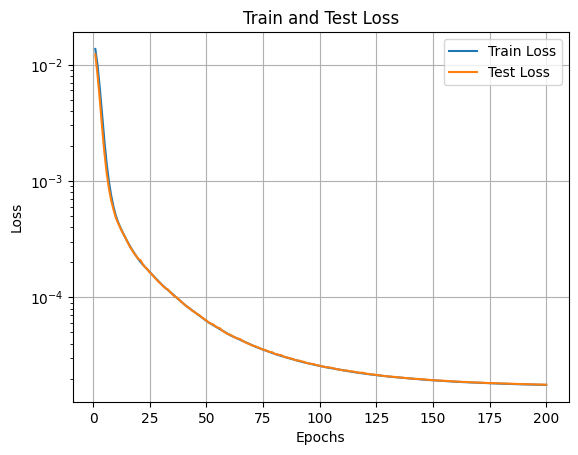

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_loss_all) + 1)



plt.plot(epochs, train_loss_all, label='Train Loss')
plt.plot(epochs, test_loss_all, label='Test Loss')

plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Loss')
plt.legend()
plt.grid()

plt.show()

In [ ]:
from google.colab import files
import os

folder_path = "/content/models/2023-05-06_14-03-38"  # The path to the folder you want to zip
zip_name = "zipped_folder.zip"  # Name of the zip file to be created

# Create the zip file
!zip -r {zip_name} {folder_path}

# Check if the zip file was created and download it
if os.path.exists(zip_name):
    files.download(zip_name)
else:
    print(f"Error: {zip_name} not found")


  adding: content/models/2023-05-06_14-03-38/ (stored 0%)
  adding: content/models/2023-05-06_14-03-38/epoch_0049/ (stored 0%)
  adding: content/models/2023-05-06_14-03-38/epoch_0049/dynamics.pth (deflated 8%)
  adding: content/models/2023-05-06_14-03-38/epoch_0013/ (stored 0%)
  adding: content/models/2023-05-06_14-03-38/epoch_0013/dynamics.pth (deflated 8%)
  adding: content/models/2023-05-06_14-03-38/epoch_0075/ (stored 0%)
  adding: content/models/2023-05-06_14-03-38/epoch_0075/dynamics.pth (deflated 8%)
  adding: content/models/2023-05-06_14-03-38/epoch_0185/ (stored 0%)
  adding: content/models/2023-05-06_14-03-38/epoch_0185/dynamics.pth (deflated 8%)
  adding: content/models/2023-05-06_14-03-38/epoch_0063/ (stored 0%)
  adding: content/models/2023-05-06_14-03-38/epoch_0063/dynamics.pth (deflated 8%)
  adding: content/models/2023-05-06_14-03-38/epoch_0019/ (stored 0%)
  adding: content/models/2023-05-06_14-03-38/epoch_0019/dynamics.pth (deflated 8%)
  adding: content/models/2023-

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Part 2.4: Completing ArmDynamicsStudent

After done with training, the ArmDynamicsStudent class need to be compelete following the comments below to load the saved checkpoint (in function init_model) and then use it to predict the new state given the current state and action (in function dynamics_step). Please do not modify the arguments to those functions, even though they might not all be used.

In [ ]:
from arm_dynamics_base import ArmDynamicsBase

class ArmDynamicsStudent(ArmDynamicsBase):
    def init_model(self, model_path, num_links, time_step, device):
        # ---
        # Initialize the model loading the saved model from provided model_path
        self.model = Model2Link(0.01)
        # ---
        self.model.load_state_dict(torch.load(model_path))
        self.model.eval()
        self.model_loaded = True

    def dynamics_step(self, state, action, dt):
        if self.model_loaded:
            # ---
            # Use the loaded model to predict new state given the current state and action
            x = np.append(state, action)
            new_state = self.model.predict(x)
            return new_state.T
            # ---
        else:
            return state

### Manually Testing the MPC Controller with the learnt dynamics model
Now use the learnt dynamics model will be used. The model is loaded in the dynamics.init_model method. The goal positions can be modified to see how well is the controller performing similar to before. Feel free to play around with the code in this cell to test the performance before the grading part.


In [ ]:
import sys
import numpy as np
from arm_dynamics_teacher import ArmDynamicsTeacher
from robot import Robot
from render import Renderer
from score import *
import torch
import time

# Teacher arm with 2 links
dynamics_teacher = ArmDynamicsTeacher(
    num_links=2,
    link_mass=0.1,
    link_length=1,
    joint_viscous_friction=0.1,
    dt=0.01)

arm = Robot(dynamics_teacher)
arm.reset()

gui = False
action = np.zeros((arm.dynamics.get_action_dim(), 1))
if gui:
  renderer = Renderer()
  time.sleep(1)

def sample_goal():
      goal = np.zeros((2,1))
      r = np.random.uniform(low=0.05, high=1.95)
      theta = np.random.uniform(low=np.pi, high=2.0*np.pi)
      goal[0,0] = r * np.cos(theta)
      goal[1,0] = r * np.sin(theta)
      return goal


# Controller
controller = MPC()
dynamics_student = ArmDynamicsStudent(
    num_links=2,
    link_mass=0.1,
    link_length=1,
    joint_viscous_friction=0.1,
    dt=0.01)
device = torch.device('cpu')



dist_err_epoch = []
vel_ee_err_epoch = [] 
num_points = 5

dt = 0.01
time_limit = 2
num_steps = round(time_limit/dt)


model_dir = '/content/unzipped_folder/content/models/2023-05-06_14-03-38'

from tqdm import tqdm 
for epoch in tqdm(range(2, 201)):
    model_folder = f'epoch_{epoch:04d}'
    model_path = os.path.join(model_dir, model_folder, 'dynamics.pth')

    if os.path.exists(model_path):
        dynamics_student.init_model(model_path, 2, 0.01, device)
        print(f"Loaded model: {model_path}")
    # dynamics_student.init_model(model_path, 2, 0.01, device)

    dist_err = 0
    vel_ee_err = 0

    # Control loop

    for i in range(num_points):
        arm.reset()
        action = np.zeros((arm.dynamics.get_action_dim(), 1))
        goal = sample_goal()
        arm.goal = goal


        for s in range(num_steps):

          t = time.time()
          arm.advance()

          if gui:
            renderer.plot([(arm, "tab:blue")])
          time.sleep(max(0, dt - (time.time() - t)))

          if s % controller.control_horizon==0:
            state = arm.get_state()
            action = controller.compute_action(dynamics_student, state, goal, action)
            pos_ee = dynamics_teacher.compute_fk(state)
            dist = np.linalg.norm(goal-pos_ee)
            vel_ee = np.linalg.norm(arm.dynamics.compute_vel_ee(state))
            dist_err += dist
            vel_ee_err += vel_ee

            # print(f'At timestep {s}: Distance to goal: {dist}, Velocity of end effector: {vel_ee}')
            # print(action)
            arm.set_action(action)

    dist_err_epoch.append(dist_err/num_points)
    vel_ee_err_epoch.append(vel_ee_err/num_points)

  0%|          | 0/199 [00:00<?, ?it/s]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0002/dynamics.pth


  1%|          | 1/199 [02:15<7:25:47, 135.09s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0003/dynamics.pth


  1%|          | 2/199 [03:11<4:51:13, 88.70s/it] 

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0004/dynamics.pth


  2%|▏         | 3/199 [03:53<3:40:14, 67.42s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0005/dynamics.pth


  2%|▏         | 4/199 [04:36<3:07:43, 57.76s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0006/dynamics.pth


  3%|▎         | 5/199 [05:16<2:46:29, 51.49s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0007/dynamics.pth


  3%|▎         | 6/199 [06:00<2:37:04, 48.83s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0008/dynamics.pth


  4%|▎         | 7/199 [06:46<2:33:17, 47.90s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0009/dynamics.pth


  4%|▍         | 8/199 [07:32<2:31:03, 47.45s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0010/dynamics.pth


  5%|▍         | 9/199 [08:23<2:33:19, 48.42s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0011/dynamics.pth


  5%|▌         | 10/199 [09:12<2:33:29, 48.73s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0012/dynamics.pth


  6%|▌         | 11/199 [10:08<2:39:01, 50.75s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0013/dynamics.pth


  6%|▌         | 12/199 [10:50<2:30:28, 48.28s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0014/dynamics.pth


  7%|▋         | 13/199 [11:41<2:31:56, 49.01s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0015/dynamics.pth


  7%|▋         | 14/199 [12:29<2:30:17, 48.74s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0016/dynamics.pth


  8%|▊         | 15/199 [13:13<2:25:09, 47.34s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0017/dynamics.pth


  8%|▊         | 16/199 [13:59<2:22:36, 46.76s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0018/dynamics.pth


  9%|▊         | 17/199 [14:39<2:16:01, 44.84s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0019/dynamics.pth


  9%|▉         | 18/199 [15:21<2:12:16, 43.85s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0020/dynamics.pth


 10%|▉         | 19/199 [16:06<2:13:03, 44.35s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0021/dynamics.pth


 10%|█         | 20/199 [16:41<2:03:48, 41.50s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0022/dynamics.pth


 11%|█         | 21/199 [17:32<2:11:53, 44.46s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0023/dynamics.pth


 11%|█         | 22/199 [18:14<2:08:43, 43.64s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0024/dynamics.pth


 12%|█▏        | 23/199 [19:04<2:13:25, 45.49s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0025/dynamics.pth


 12%|█▏        | 24/199 [19:48<2:11:49, 45.20s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0026/dynamics.pth


 13%|█▎        | 25/199 [20:33<2:10:56, 45.15s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0027/dynamics.pth


 13%|█▎        | 26/199 [21:18<2:10:09, 45.14s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0028/dynamics.pth


 14%|█▎        | 27/199 [21:58<2:04:52, 43.56s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0029/dynamics.pth


 14%|█▍        | 28/199 [22:37<2:00:06, 42.15s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0030/dynamics.pth


 15%|█▍        | 29/199 [23:21<2:00:59, 42.71s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0031/dynamics.pth


 15%|█▌        | 30/199 [24:01<1:57:38, 41.77s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0032/dynamics.pth


 16%|█▌        | 31/199 [24:43<1:57:14, 41.87s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0033/dynamics.pth


 16%|█▌        | 32/199 [25:26<1:57:54, 42.36s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0034/dynamics.pth


 17%|█▋        | 33/199 [26:07<1:56:05, 41.96s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0035/dynamics.pth


 17%|█▋        | 34/199 [26:49<1:55:18, 41.93s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0036/dynamics.pth


 18%|█▊        | 35/199 [27:37<1:59:04, 43.56s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0037/dynamics.pth


 18%|█▊        | 36/199 [28:18<1:56:54, 43.03s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0038/dynamics.pth


 19%|█▊        | 37/199 [29:01<1:56:01, 42.97s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0039/dynamics.pth


 19%|█▉        | 38/199 [29:46<1:57:02, 43.62s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0040/dynamics.pth


 20%|█▉        | 39/199 [30:24<1:51:43, 41.90s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0041/dynamics.pth


 20%|██        | 40/199 [31:08<1:52:22, 42.41s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0042/dynamics.pth


 21%|██        | 41/199 [31:50<1:51:11, 42.23s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0043/dynamics.pth


 21%|██        | 42/199 [32:40<1:57:08, 44.77s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0044/dynamics.pth


 22%|██▏       | 43/199 [33:21<1:52:46, 43.38s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0045/dynamics.pth


 22%|██▏       | 44/199 [34:06<1:54:02, 44.14s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0046/dynamics.pth


 23%|██▎       | 45/199 [34:53<1:55:04, 44.84s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0047/dynamics.pth


 23%|██▎       | 46/199 [35:36<1:52:43, 44.21s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0048/dynamics.pth


 24%|██▎       | 47/199 [36:22<1:53:54, 44.96s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0049/dynamics.pth


 24%|██▍       | 48/199 [37:13<1:57:12, 46.57s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0050/dynamics.pth


 25%|██▍       | 49/199 [37:54<1:52:12, 44.88s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0051/dynamics.pth


 25%|██▌       | 50/199 [38:37<1:49:59, 44.29s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0052/dynamics.pth


 26%|██▌       | 51/199 [39:17<1:46:15, 43.08s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0053/dynamics.pth


 26%|██▌       | 52/199 [39:55<1:41:59, 41.63s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0054/dynamics.pth


 27%|██▋       | 53/199 [40:40<1:44:02, 42.76s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0055/dynamics.pth


 27%|██▋       | 54/199 [41:20<1:41:17, 41.92s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0056/dynamics.pth


 28%|██▊       | 55/199 [42:04<1:41:46, 42.41s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0057/dynamics.pth


 28%|██▊       | 56/199 [42:45<1:39:51, 41.90s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0058/dynamics.pth


 29%|██▊       | 57/199 [43:27<1:39:15, 41.94s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0059/dynamics.pth


 29%|██▉       | 58/199 [44:17<1:44:15, 44.36s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0060/dynamics.pth


 30%|██▉       | 59/199 [44:58<1:41:30, 43.50s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0061/dynamics.pth


 30%|███       | 60/199 [45:43<1:42:00, 44.03s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0062/dynamics.pth


 31%|███       | 61/199 [46:24<1:38:49, 42.97s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0063/dynamics.pth


 31%|███       | 62/199 [47:05<1:36:45, 42.38s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0064/dynamics.pth


 32%|███▏      | 63/199 [47:45<1:34:10, 41.55s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0065/dynamics.pth


 32%|███▏      | 64/199 [48:28<1:34:36, 42.05s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0066/dynamics.pth


 33%|███▎      | 65/199 [49:14<1:36:23, 43.16s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0067/dynamics.pth


 33%|███▎      | 66/199 [50:01<1:38:11, 44.30s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0068/dynamics.pth


 34%|███▎      | 67/199 [50:45<1:37:54, 44.50s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0069/dynamics.pth


 34%|███▍      | 68/199 [51:28<1:35:42, 43.84s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0070/dynamics.pth


 35%|███▍      | 69/199 [52:07<1:31:47, 42.36s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0071/dynamics.pth


 35%|███▌      | 70/199 [52:50<1:31:28, 42.54s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0072/dynamics.pth


 36%|███▌      | 71/199 [53:36<1:33:04, 43.63s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0073/dynamics.pth


 36%|███▌      | 72/199 [54:16<1:30:27, 42.73s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0074/dynamics.pth


 37%|███▋      | 73/199 [54:58<1:28:43, 42.25s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0075/dynamics.pth


 37%|███▋      | 74/199 [55:40<1:27:59, 42.24s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0076/dynamics.pth


 38%|███▊      | 75/199 [56:24<1:28:48, 42.97s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0077/dynamics.pth


 38%|███▊      | 76/199 [57:14<1:32:08, 44.94s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0078/dynamics.pth


 39%|███▊      | 77/199 [57:55<1:29:04, 43.81s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0079/dynamics.pth


 39%|███▉      | 78/199 [58:44<1:31:37, 45.44s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0080/dynamics.pth


 40%|███▉      | 79/199 [59:32<1:32:00, 46.00s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0081/dynamics.pth


 40%|████      | 80/199 [1:00:14<1:29:11, 44.97s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0082/dynamics.pth


 41%|████      | 81/199 [1:00:55<1:25:55, 43.69s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0083/dynamics.pth


 41%|████      | 82/199 [1:01:36<1:23:38, 42.89s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0084/dynamics.pth


 42%|████▏     | 83/199 [1:02:19<1:23:03, 42.96s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0085/dynamics.pth


 42%|████▏     | 84/199 [1:03:05<1:23:51, 43.75s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0086/dynamics.pth


 43%|████▎     | 85/199 [1:03:45<1:21:20, 42.81s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0087/dynamics.pth


 43%|████▎     | 86/199 [1:04:31<1:22:10, 43.64s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0088/dynamics.pth


 44%|████▎     | 87/199 [1:05:14<1:21:02, 43.42s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0089/dynamics.pth


 44%|████▍     | 88/199 [1:05:58<1:20:38, 43.59s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0090/dynamics.pth


 45%|████▍     | 89/199 [1:06:37<1:17:21, 42.20s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0091/dynamics.pth


 45%|████▌     | 90/199 [1:07:27<1:20:49, 44.49s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0092/dynamics.pth


 46%|████▌     | 91/199 [1:08:08<1:18:21, 43.54s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0093/dynamics.pth


 46%|████▌     | 92/199 [1:08:47<1:15:14, 42.19s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0094/dynamics.pth


 47%|████▋     | 93/199 [1:09:27<1:13:38, 41.68s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0095/dynamics.pth


 47%|████▋     | 94/199 [1:10:16<1:16:47, 43.88s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0096/dynamics.pth


 48%|████▊     | 95/199 [1:11:02<1:16:41, 44.24s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0097/dynamics.pth


 48%|████▊     | 96/199 [1:11:48<1:17:19, 45.04s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0098/dynamics.pth


 49%|████▊     | 97/199 [1:12:34<1:16:54, 45.24s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0099/dynamics.pth


 49%|████▉     | 98/199 [1:13:14<1:13:26, 43.63s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0100/dynamics.pth


 50%|████▉     | 99/199 [1:13:56<1:11:40, 43.01s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0101/dynamics.pth


 50%|█████     | 100/199 [1:14:35<1:09:15, 41.97s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0102/dynamics.pth


 51%|█████     | 101/199 [1:15:14<1:07:10, 41.13s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0103/dynamics.pth


 51%|█████▏    | 102/199 [1:16:00<1:08:33, 42.41s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0104/dynamics.pth


 52%|█████▏    | 103/199 [1:16:41<1:07:28, 42.17s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0105/dynamics.pth


 52%|█████▏    | 104/199 [1:17:25<1:07:38, 42.72s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0106/dynamics.pth


 53%|█████▎    | 105/199 [1:18:05<1:05:40, 41.92s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0107/dynamics.pth


 53%|█████▎    | 106/199 [1:18:47<1:04:42, 41.75s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0108/dynamics.pth


 54%|█████▍    | 107/199 [1:19:35<1:07:08, 43.79s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0109/dynamics.pth


 54%|█████▍    | 108/199 [1:20:21<1:07:19, 44.39s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0110/dynamics.pth


 55%|█████▍    | 109/199 [1:21:01<1:04:23, 42.93s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0111/dynamics.pth


 55%|█████▌    | 110/199 [1:21:49<1:05:59, 44.49s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0112/dynamics.pth


 56%|█████▌    | 111/199 [1:22:32<1:04:44, 44.14s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0113/dynamics.pth


 56%|█████▋    | 112/199 [1:23:14<1:03:07, 43.53s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0114/dynamics.pth


 57%|█████▋    | 113/199 [1:23:59<1:03:03, 43.99s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0115/dynamics.pth


 57%|█████▋    | 114/199 [1:24:42<1:01:36, 43.49s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0116/dynamics.pth


 58%|█████▊    | 115/199 [1:25:24<1:00:29, 43.21s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0117/dynamics.pth


 58%|█████▊    | 116/199 [1:26:07<59:37, 43.10s/it]  

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0118/dynamics.pth


 59%|█████▉    | 117/199 [1:26:47<57:37, 42.17s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0119/dynamics.pth


 59%|█████▉    | 118/199 [1:27:30<57:20, 42.47s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0120/dynamics.pth


 60%|█████▉    | 119/199 [1:28:17<58:33, 43.92s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0121/dynamics.pth


 60%|██████    | 120/199 [1:29:02<58:05, 44.12s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0122/dynamics.pth


 61%|██████    | 121/199 [1:29:44<56:27, 43.43s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0123/dynamics.pth


 61%|██████▏   | 122/199 [1:30:28<56:01, 43.66s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0124/dynamics.pth


 62%|██████▏   | 123/199 [1:31:14<56:08, 44.32s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0125/dynamics.pth


 62%|██████▏   | 124/199 [1:31:59<55:31, 44.42s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0126/dynamics.pth


 63%|██████▎   | 125/199 [1:32:44<55:09, 44.72s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0127/dynamics.pth


 63%|██████▎   | 126/199 [1:33:26<53:26, 43.92s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0128/dynamics.pth


 64%|██████▍   | 127/199 [1:34:14<54:15, 45.22s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0129/dynamics.pth


 64%|██████▍   | 128/199 [1:34:58<53:08, 44.90s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0130/dynamics.pth


 65%|██████▍   | 129/199 [1:35:43<52:12, 44.75s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0131/dynamics.pth


 65%|██████▌   | 130/199 [1:36:28<51:39, 44.93s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0132/dynamics.pth


 66%|██████▌   | 131/199 [1:37:12<50:35, 44.64s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0133/dynamics.pth


 66%|██████▋   | 132/199 [1:37:59<50:34, 45.29s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0134/dynamics.pth


 67%|██████▋   | 133/199 [1:38:39<48:03, 43.68s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0135/dynamics.pth


 67%|██████▋   | 134/199 [1:39:19<46:03, 42.52s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0136/dynamics.pth


 68%|██████▊   | 135/199 [1:40:05<46:29, 43.59s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0137/dynamics.pth


 68%|██████▊   | 136/199 [1:40:49<45:54, 43.72s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0138/dynamics.pth


 69%|██████▉   | 137/199 [1:41:38<47:00, 45.49s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0139/dynamics.pth


 69%|██████▉   | 138/199 [1:42:24<46:11, 45.43s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0140/dynamics.pth


 70%|██████▉   | 139/199 [1:43:15<47:15, 47.25s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0141/dynamics.pth


 70%|███████   | 140/199 [1:43:59<45:34, 46.34s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0142/dynamics.pth


 71%|███████   | 141/199 [1:44:41<43:32, 45.04s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0143/dynamics.pth


 71%|███████▏  | 142/199 [1:45:25<42:26, 44.67s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0144/dynamics.pth


 72%|███████▏  | 143/199 [1:46:09<41:20, 44.29s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0145/dynamics.pth


 72%|███████▏  | 144/199 [1:46:54<40:56, 44.66s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0146/dynamics.pth


 73%|███████▎  | 145/199 [1:47:36<39:24, 43.79s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0147/dynamics.pth


 73%|███████▎  | 146/199 [1:48:19<38:22, 43.44s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0148/dynamics.pth


 74%|███████▍  | 147/199 [1:49:01<37:29, 43.25s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0149/dynamics.pth


 74%|███████▍  | 148/199 [1:49:48<37:34, 44.20s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0150/dynamics.pth


 75%|███████▍  | 149/199 [1:50:33<37:10, 44.61s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0151/dynamics.pth


 75%|███████▌  | 150/199 [1:51:24<37:50, 46.34s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0152/dynamics.pth


 76%|███████▌  | 151/199 [1:52:06<36:00, 45.02s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0153/dynamics.pth


 76%|███████▋  | 152/199 [1:52:50<35:09, 44.89s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0154/dynamics.pth


 77%|███████▋  | 153/199 [1:53:33<33:54, 44.24s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0155/dynamics.pth


 77%|███████▋  | 154/199 [1:54:20<33:43, 44.98s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0156/dynamics.pth


 78%|███████▊  | 155/199 [1:55:06<33:17, 45.39s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0157/dynamics.pth


 78%|███████▊  | 156/199 [1:55:49<32:01, 44.69s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0158/dynamics.pth


 79%|███████▉  | 157/199 [1:56:37<31:55, 45.61s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0159/dynamics.pth


 79%|███████▉  | 158/199 [1:57:20<30:39, 44.86s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0160/dynamics.pth


 80%|███████▉  | 159/199 [1:58:06<30:07, 45.20s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0161/dynamics.pth


 80%|████████  | 160/199 [1:58:49<29:00, 44.63s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0162/dynamics.pth


 81%|████████  | 161/199 [1:59:30<27:33, 43.52s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0163/dynamics.pth


 81%|████████▏ | 162/199 [2:00:17<27:24, 44.45s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0164/dynamics.pth


 82%|████████▏ | 163/199 [2:01:01<26:40, 44.46s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0165/dynamics.pth


 82%|████████▏ | 164/199 [2:01:40<25:00, 42.88s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0166/dynamics.pth


 83%|████████▎ | 165/199 [2:02:26<24:48, 43.78s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0167/dynamics.pth


 83%|████████▎ | 166/199 [2:03:03<22:57, 41.75s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0168/dynamics.pth


 84%|████████▍ | 167/199 [2:03:50<23:04, 43.27s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0169/dynamics.pth


 84%|████████▍ | 168/199 [2:04:35<22:32, 43.64s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0170/dynamics.pth


 85%|████████▍ | 169/199 [2:05:18<21:45, 43.51s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0171/dynamics.pth


 85%|████████▌ | 170/199 [2:06:02<21:09, 43.77s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0172/dynamics.pth


 86%|████████▌ | 171/199 [2:06:44<20:10, 43.23s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0173/dynamics.pth


 86%|████████▋ | 172/199 [2:07:25<19:10, 42.60s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0174/dynamics.pth


 87%|████████▋ | 173/199 [2:08:11<18:53, 43.59s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0175/dynamics.pth


 87%|████████▋ | 174/199 [2:08:52<17:48, 42.75s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0176/dynamics.pth


 88%|████████▊ | 175/199 [2:09:38<17:30, 43.75s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0177/dynamics.pth


 88%|████████▊ | 176/199 [2:10:21<16:40, 43.50s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0178/dynamics.pth


 89%|████████▉ | 177/199 [2:11:06<16:03, 43.81s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0179/dynamics.pth


 89%|████████▉ | 178/199 [2:11:49<15:18, 43.76s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0180/dynamics.pth


 90%|████████▉ | 179/199 [2:12:36<14:51, 44.58s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0181/dynamics.pth


 90%|█████████ | 180/199 [2:13:18<13:51, 43.79s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0182/dynamics.pth


 91%|█████████ | 181/199 [2:14:03<13:16, 44.25s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0183/dynamics.pth


 91%|█████████▏| 182/199 [2:14:44<12:14, 43.23s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0184/dynamics.pth


 92%|█████████▏| 183/199 [2:15:26<11:24, 42.79s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0185/dynamics.pth


 92%|█████████▏| 184/199 [2:16:10<10:50, 43.37s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0186/dynamics.pth


 93%|█████████▎| 185/199 [2:16:53<10:05, 43.24s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0187/dynamics.pth


 93%|█████████▎| 186/199 [2:17:40<09:37, 44.43s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0188/dynamics.pth


 94%|█████████▍| 187/199 [2:18:28<09:02, 45.24s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0189/dynamics.pth


 94%|█████████▍| 188/199 [2:19:07<07:59, 43.55s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0190/dynamics.pth


 95%|█████████▍| 189/199 [2:19:53<07:22, 44.26s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0191/dynamics.pth


 95%|█████████▌| 190/199 [2:20:33<06:26, 42.99s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0192/dynamics.pth


 96%|█████████▌| 191/199 [2:21:16<05:43, 42.92s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0193/dynamics.pth


 96%|█████████▋| 192/199 [2:21:57<04:56, 42.37s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0194/dynamics.pth


 97%|█████████▋| 193/199 [2:22:36<04:07, 41.29s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0195/dynamics.pth


 97%|█████████▋| 194/199 [2:23:19<03:29, 41.88s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0196/dynamics.pth


 98%|█████████▊| 195/199 [2:24:08<02:56, 44.14s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0197/dynamics.pth


 98%|█████████▊| 196/199 [2:24:53<02:12, 44.22s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0198/dynamics.pth


 99%|█████████▉| 197/199 [2:25:42<01:31, 45.75s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0199/dynamics.pth


 99%|█████████▉| 198/199 [2:26:24<00:44, 44.50s/it]

Loaded model: /content/unzipped_folder/content/models/2023-05-06_14-03-38/epoch_0200/dynamics.pth


100%|██████████| 199/199 [2:27:04<00:00, 44.35s/it]


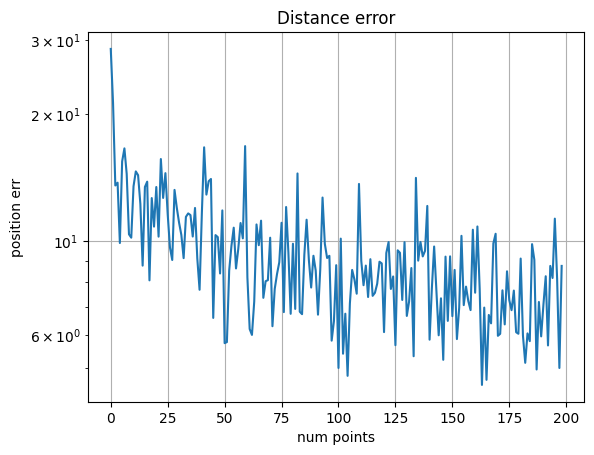

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.yscale('log')
plt.plot(dist_err_epoch)
plt.xlabel('num points')
plt.ylabel('position err')
plt.title('Distance error')
# plt.legend(['State 1', 'State 2'])
plt.grid()
plt.show()

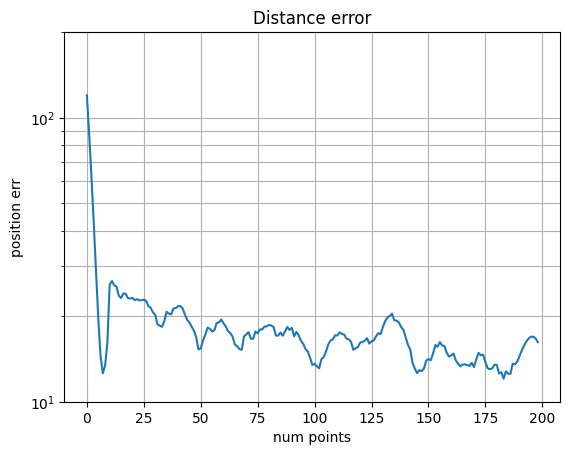

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
dist_err_epoch = np.array(dist_err_epoch)

smoothed_data = savgol_filter(dist_err_epoch, window_length=20, polyorder=3)

plt.figure()
plt.yscale('log')
plt.plot(smoothed_data)
plt.xlabel('num points')
plt.ylabel('position err')
plt.title('Distance error')
min_value = 1e1
max_value = 2e2
plt.ylim(min_value, max_value)

# Display grid lines
plt.grid(which='both')

plt.show()


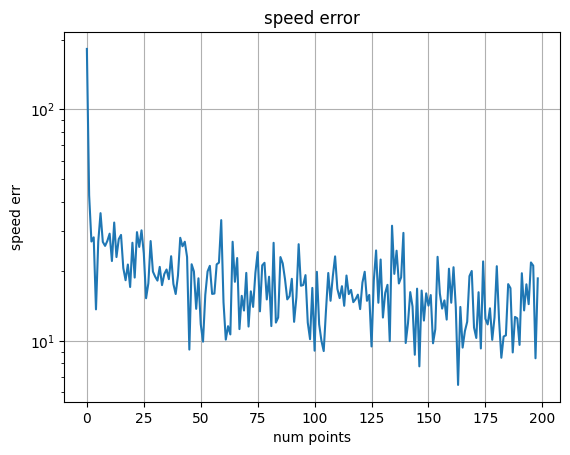

In [ ]:
plt.figure()
plt.yscale('log')
plt.plot(vel_ee_err_epoch)
plt.xlabel('num points')
plt.ylabel('speed err')
plt.title('speed error')
# plt.legend(['State 1', 'State 2'])
plt.grid()
plt.show()

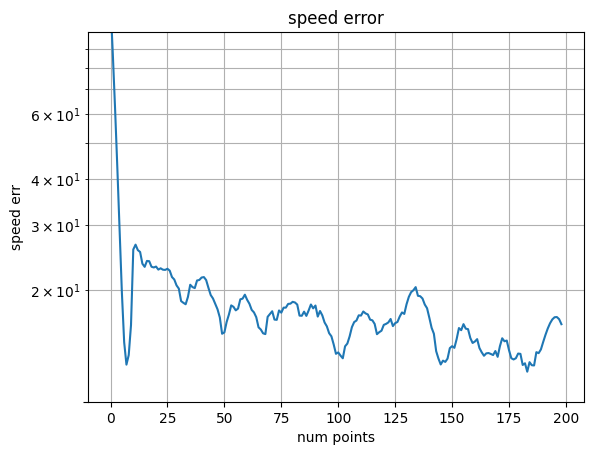

In [ ]:

dist_err_epoch = np.array(vel_ee_err_epoch)

# Apply the Savitzky-Golay filter to smooth the curve
# You can change the window_length and polyorder parameters to see what works best for your data
smoothed_data = savgol_filter(vel_ee_err_epoch, window_length=20, polyorder=3)

plt.figure()
plt.yscale('log')
plt.plot(smoothed_data)
plt.xlabel('num points')
plt.ylabel('speed err')
plt.title('speed error')
min_value = 1e1  # Replace with your desired minimum value
max_value = 1e2   # Replace with your desired maximum value
plt.ylim(min_value, max_value)
# plt.legend(['State 1', 'State 2'])
# Customize y-axis ticks and grid lines
y_ticks = np.logspace(np.log10(min_value), np.log10(max_value), num=1) # You can change num to control the number of ticks
plt.yticks(y_ticks, []) # Set yticklabels to an empty list
plt.gca().yaxis.grid(True, which='both') # Show major and minor grid lines

plt.grid()
plt.show()


## Grading and Evaluation of Part 2
The model will be evaluated on how well the controller+learnt dynamics works together. The scoring functions consists of 16 random test goals all of which will be below the x axis and between 0.05 to 1.95 lengths away from the origin.
The controller will call the compute_action method from your MPC class and apply the action for 10 timesteps
```
action = controller.compute_action(dynamics_student, state, goal, action)
```

Each test will run the robot arm for **2.5 seconds**. At the end of the 2.5 seconds the test will be:

A success if the end effectors meet this criteria:
`distance_to_goal < 0.2 and vel_ee < 0.5` 

A partial success if the end effectors meet this criteria:
`distance_to_goal < 0.3 and vel_ee < 0.5` 

You need 15 out of the 16 tests to succeed to get a full score

In [ ]:
controller = MPC()
dynamics_student = ArmDynamicsStudent(
    num_links=2,
    link_mass=0.1,
    link_length=1,
    joint_viscous_friction=0.1,
    dt=0.01)
model_path = '/content/models/2023-05-06_04-57-22/epoch_0040/dynamics.pth'
gui=False

In [ ]:
# DO NOT CHANGE
score_mpc_learnt_dynamics(controller, dynamics_student, model_path, gui)

Part2: EVALUATING CONTROLLER + LEARNED DYNAMICS
-----------------------------------------------
NUM_LINKS: 2
Test  1
Fail :(
 Goal: [-0.53075893 -0.22742767], Final position: [ 1.14840834 -0.98908424], Final velocity: [3.06178803]
score: 0/0.5
Test  2
Fail :(
 Goal: [ 0.78862946 -0.10868751], Final position: [ 0.90666958 -0.08641431], Final velocity: [1.15328823]
score: 0/0.5
Test  3
Fail :(
 Goal: [ 0.387238   -0.12048435], Final position: [-0.19005177  0.28720221], Final velocity: [0.28339519]
score: 0/0.5
Test  4
Success! :)
 Goal: [-0.1461861 -1.0733218], Final position: [-0.109789   -0.98892475], Final velocity: [0.48143715]
score: 0.5/0.5
Test  5
Success! :)
 Goal: [-0.22381749 -1.71130446], Final position: [-0.26248247 -1.67282309], Final velocity: [0.33504807]
score: 0.5/0.5
Test  6
Partial success :|
 Goal: [-0.4447835 -1.3547735], Final position: [-0.24967787 -1.43937246], Final velocity: [0.33330483]
score: 0.3/0.5
Test  7
Fail :(
 Goal: [ 0.9937009  -1.46193928], Final posi

KeyboardInterrupt: ignored